In [ ]:
import numpy as np,pandas as pd,matplotlib,json,ast
import matplotlib.pyplot as plt
SRC=r"D:\Sandy\科定\data-1758877864792.csv";PH="PH.decPressureRinse5";TOP="Pressure.decTopWater";TSCOL="create_date"
CUT_DEFAULT=0.35;Q_MAIN=0.10;Q_SEV=0.05
matplotlib.rcParams['font.sans-serif']=['Microsoft JhengHei','Microsoft YaHei','SimHei','PMingLiU','Arial Unicode MS'];matplotlib.rcParams['axes.unicode_minus']=False
def pjson(s):
 if pd.isna(s):return{}
 if isinstance(s,dict):return s
 t=str(s).strip()
 if(not t)or(t.lower()in("nan","none","null")):return{}
 try:return json.loads(t)
 except:
  try:v=ast.literal_eval(t);return v if isinstance(v,dict)else{}
  except:return{}
#讀檔+展開
raw=pd.read_csv(SRC,low_memory=False)
if TSCOL not in raw.columns:raise SystemExit(f"找不到時間欄位:{TSCOL}")
j=pd.json_normalize(raw["json_data"].dropna().apply(pjson),sep=".")
for c in(PH,TOP):
 if c not in j.columns:raise SystemExit(f"找不到欄位:{c}")
df=j[[PH,TOP]].apply(pd.to_numeric,errors="coerce").copy()
#對齊原始時間索引→加時間欄位
df["ts"]=pd.to_datetime(raw.loc[j.index,TSCOL],errors="coerce")
df=df.dropna(subset=["ts",PH]).sort_values("ts").reset_index(drop=True)
#TopWater分檔
vals=df[TOP].dropna()
if vals.empty:raise SystemExit("TopWater無有效數據。")
lo,hi=float(vals.min()),float(vals.max());cut_point=CUT_DEFAULT if(lo<=CUT_DEFAULT<=hi)else float(vals.median())
def bucket(x,cp=cut_point,eps=1e-9):
 if pd.isna(x):return"NA"
 x=float(x)
 if x<=0.0+eps:return"OFF"
 if x<=0.01+eps:return"LOW"
 return"LOW"if x<=cp+eps else"HIGH"
df["TopWater_bin"]=df[TOP].map(bucket)
#門檻(分位數)與事件旗標
TH_MAIN=float(df[PH].quantile(Q_MAIN));TH_SEV=float(df[PH].quantile(Q_SEV))
df["evt_main"]=(df[PH]<TH_MAIN).astype(int);df["evt_sev"]=(df[PH]<TH_SEV).astype(int)
#時間特徵
dt=pd.to_datetime(df["ts"]);df["hour"]=dt.dt.hour;df["date"]=dt.dt.date
def shift_of(h):
 if 8<=h<=15:return"DAY(08-15)"
 if 16<=h<=23:return"EVE(16-23)"
 return"NIGHT(00-07)"
df["shift"]=df["hour"].map(shift_of)
#求1小時滾動視窗n(用時間戳中位間隔估計)
def infer_window_n(ts,sec=3600):
 d=pd.Series(ts).diff().dt.total_seconds().dropna();med=float(d.median())if len(d)else 60.0
 if med<=0:med=60.0
 return max(5,int(round(sec/med)))
#——TopWater分檔統計圖——
order=[b for b in["OFF","LOW","HIGH"]if df["TopWater_bin"].eq(b).any()]
data=[df.loc[df["TopWater_bin"]==k,PH].dropna() for k in order];counts=[len(d) for d in data];labels=[f"{lab}\n(n={n})"for lab,n in zip(order,counts)]
def plot_box():
 fig,ax=plt.subplots(figsize=(8,6));ax.boxplot(data,labels=labels,showmeans=True)
 ax.set_title("PR5 pH（依補水檔位 OFF/LOW/HIGH）盒鬚圖");ax.set_xlabel("TopWater檔位");ax.set_ylabel("PR5 pH")
 ax.axhline(TH_MAIN,linestyle="--",label=f"輕度門檻=pH{TH_MAIN:.2f}",zorder=2);ax.axhline(TH_SEV,linestyle=":",label=f"重度門檻=pH{TH_SEV:.2f}",zorder=2)
 ax.legend(loc="lower right")
 rate_main=(df[PH]<TH_MAIN).groupby(df["TopWater_bin"]).mean().reindex(order);rate_sev=(df[PH]<TH_SEV).groupby(df["TopWater_bin"]).mean().reindex(order)
 y0,y1=ax.get_ylim();dy=(y1-y0)*0.03;dx=0.18;sty=dict(bbox=dict(facecolor="white",alpha=0.9,edgecolor="none",pad=1),ha="right",va="top",zorder=10,clip_on=False,fontsize=10)
 for i,lab in enumerate(order,1):
  if lab in rate_main.index and pd.notna(rate_main.loc[lab]):ax.text(i-dx,TH_MAIN-dy,f"{rate_main.loc[lab]:.1%}",**sty)
  if lab in rate_sev.index and pd.notna(rate_sev.loc[lab]):ax.text(i-dx,TH_SEV-dy,f"{rate_sev.loc[lab]:.1%}",**sty)
 txt=f"檔位界定：OFF≤0｜LOW：(0,0.01]或(0.01,{cut_point:.2f}]｜HIGH：>{cut_point:.2f}"
 plt.gcf().text(0.5,0.02,txt,ha="center",va="bottom");plt.tight_layout(rect=[0,0.05,1,1])
def plot_bar():
 evt=(df[PH]<TH_MAIN).astype(int);rate=evt.groupby(df["TopWater_bin"]).mean().reindex(order);cnt=df.groupby("TopWater_bin")[PH].size().reindex(order)
 plt.figure(figsize=(6,5));plt.bar(order,rate.values);plt.title(f"PR5事件率(低於q{int(Q_MAIN*100)}分位)");plt.xlabel("TopWater檔位");plt.ylabel("事件率")
 for i,(lab,y) in enumerate(zip(order,rate.values)):plt.text(i,y,f"{y:.1%}\n(n={cnt.loc[lab]})",ha="center",va="bottom")
 plt.tight_layout()
#——時間相關圖(只顯示pH與TopWater條帶)——
def plot_timeseries():
 n=infer_window_n(df["ts"]);roll=df[PH].rolling(n,min_periods=max(3,n//4)).mean()
 fig,ax=plt.subplots(figsize=(12,5))
 ax.plot(df["ts"],df[PH],linewidth=0.8,label="PR5 pH");ax.plot(df["ts"],roll,linewidth=2,label=f"pH滾動均線(~1h,n={n})")
 ax.axhline(TH_MAIN,linestyle="--",label=f"q{int(Q_MAIN*100)}=pH{TH_MAIN:.2f}");ax.axhline(TH_SEV,linestyle=":",label=f"q{int(Q_SEV*100)}=pH{TH_SEV:.2f}")
 ax.set_xlabel("時間");ax.set_ylabel("PR5 pH")
 state=df["TopWater_bin"].fillna("NA").values;tsv=df["ts"].values
 def span(s,e,label):
  if label=="OFF":ax.axvspan(tsv[s],tsv[e-1],alpha=0.12)
  elif label=="LOW":ax.axvspan(tsv[s],tsv[e-1],alpha=0.08)
 s=0
 for i in range(1,len(state)):
  if state[i]!=state[s]:span(s,i,state[s]);s=i
 span(s,len(state),state[s])
 ax.legend(loc="lower right");plt.tight_layout();plt.show()
def plot_hourly_event_rate():
 r=df.groupby("hour")["evt_main"].mean();c=df.groupby("hour")["evt_main"].size()
 plt.figure(figsize=(9,4));plt.bar(r.index,r.values)
 for h in r.index:plt.text(h,r.loc[h],f"{r.loc[h]:.1%}\n(n={c.loc[h]})",ha="center",va="bottom",fontsize=9)
 plt.title(f"事件率(pH<q{int(Q_MAIN*100)})—每小時");plt.xlabel("小時(0-23)");plt.ylabel("事件率");plt.tight_layout();plt.show()
def plot_shift_event_rate():
 order_s=["NIGHT(00-07)","DAY(08-15)","EVE(16-23)"]
 r=df.groupby("shift")["evt_main"].mean().reindex(order_s);c=df.groupby("shift")["evt_main"].size().reindex(order_s)
 plt.figure(figsize=(6,4));plt.bar(r.index,r.values)
 for i,sf in enumerate(r.index):plt.text(i,r.loc[sf],f"{r.loc[sf]:.1%}\n(n={c.loc[sf]})",ha="center",va="bottom",fontsize=9)
 plt.title(f"事件率(pH<q{int(Q_MAIN*100)})—班別");plt.xlabel("班別");plt.ylabel("事件率");plt.tight_layout();plt.show()
def plot_day_hour_heatmap():
 piv=(df.groupby(["date","hour"])["evt_main"].mean().reset_index().pivot(index="date",columns="hour",values="evt_main").fillna(0.0))
 plt.figure(figsize=(12,0.5+0.4*len(piv)));im=plt.imshow(piv.values,aspect="auto",origin="upper")
 plt.colorbar(im,label=f"事件率(pH<q{int(Q_MAIN*100)})");plt.xticks(ticks=np.arange(0,24),labels=[str(h)for h in range(24)])
 plt.yticks(ticks=np.arange(len(piv.index)),labels=[str(d)for d in piv.index]);plt.title("事件率熱圖（日期×小時）");plt.xlabel("小時(0-23)");plt.ylabel("日期");plt.tight_layout();plt.show()
#——出圖(TopWater專注)——
#plot_timeseries()
plot_hourly_event_rate()
#plot_shift_event_rate()
plot_day_hour_heatmap()
plot_box()
#plot_bar()


In [ ]:
import pandas as pd,numpy as np,json,ast

SRC=r"D:\Sandy\科定\data-1758877864792.csv"

FLOW_PAIRS=[
 ("FlowRate.decE1A","FlowRate.decE1B"),
 ("FlowRate.decE2Up","FlowRate.decE2Down"),
 ("FlowRate.decE3Up","FlowRate.decE3Down"),
 ("FlowRate.decE4Up","FlowRate.decE4Down"),
]
CYCLE_TESTS=[
 ("FlowRate.decE1Cycle",["FlowRate.decE1A","FlowRate.decE1B"]),
 ("FlowRate.decE3Cycle",["FlowRate.decE3Up","FlowRate.decE3Down"]),
]
ALL_FLOW=[
 "FlowRate.decD1","FlowRate.decD2",
 "FlowRate.decE1A","FlowRate.decE1B",
 "FlowRate.decE2Up","FlowRate.decE2Down",
 "FlowRate.decE3Up","FlowRate.decE3Down",
 "FlowRate.decE4Up","FlowRate.decE4Down",
 "FlowRate.decE1Cycle","FlowRate.decE3Cycle",
 "FlowRate.decOverFlow4","FlowRate.decOverFlow7","FlowRate.decOverFlow9",
 "FlowRate.decPressureRinse5"
]

def pjson(s):
    if pd.isna(s): return {}
    if isinstance(s,dict): return s
    t=str(s).strip()
    if not t or t.lower() in ("nan","none","null"): return {}
    try: return json.loads(t)
    except:
        try:
            v=ast.literal_eval(t)
            return v if isinstance(v,dict) else {}
        except: return {}

raw=pd.read_csv(SRC,low_memory=False)
j=pd.json_normalize(raw["json_data"].dropna().apply(pjson),sep=".")
df=j[[c for c in ALL_FLOW if c in j.columns]].apply(pd.to_numeric,errors="coerce")

print("=== 常數/近常數/尖峰檢查 ===")
desc=df.describe().T
zeros=(df==0).sum()/len(df)
z=(df-df.mean())/df.std()
spike=(np.abs(z)>3).sum()/len(df)
cv=lambda s: float(s.std()/s.mean()) if pd.notna(s.mean()) and s.mean()!=0 else np.nan
desc["pct_zero"]=zeros
desc["cv"]=df.apply(cv,axis=0)
desc["pct_spike(|z|>3)"]=spike
print(desc[["count","mean","std","min","max","pct_zero","cv","pct_spike(|z|>3)"]].round(3).to_string())

const_like=desc.index[(desc["std"].fillna(0)==0)|(desc["pct_zero"]>=0.95)].tolist()
if const_like:
    print("\n[警示] 常數/近常數欄位：",", ".join(const_like))

print("\n=== 並聯對相關（期望 r≥0.70）===")
for a,b in FLOW_PAIRS:
    if a in df.columns and b in df.columns:
        pair=df[[a,b]].dropna()
        r=pair.corr().iloc[0,1] if len(pair)>30 else np.nan
        print(f"- {a} vs {b}: r={np.round(r,3)}  {'<< 需巡檢' if pd.notna(r) and abs(r)<0.7 else ''}")

print("\n=== Cycle vs 同槽合計（期望 r≥0.60）===")
for cyc,parts in CYCLE_TESTS:
    if cyc in df.columns and any(p in df.columns for p in parts):
        s=df[parts].sum(axis=1,min_count=1)
        pair=pd.concat([df[cyc],s],axis=1).dropna()
        r=pair.corr().iloc[0,1] if len(pair)>30 else np.nan
        print(f"- {cyc} vs {'+'.join([p for p in parts if p in df.columns])}: r={np.round(r,3)}  {'<< 需檢查旁通/感測' if pd.notna(r) and abs(r)<0.6 else ''}")

print("\n=== Up/Down 長期不均衡（中位數比值，期望接近 1）===")
def ratio_report(up,down):
    if up in df.columns and down in df.columns:
        sub=df[[up,down]].dropna()
        if len(sub)>100:
            ratio=(sub[up]+1e-6)/(sub[down]+1e-6)
            med=float(ratio.median())
            p_lo=float((ratio<0.8).mean()); p_hi=float((ratio>1.25).mean())
            print(f"- {up}/{down}: median={med:.2f}, 低於0.8比例={p_lo:.1%}, 高於1.25比例={p_hi:.1%}  {'<< 可能偏流/噴嘴堵' if p_lo>0.2 or p_hi>0.2 else ''}")

ratio_report("FlowRate.decE2Up","FlowRate.decE2Down")
ratio_report("FlowRate.decE3Up","FlowRate.decE3Down")
ratio_report("FlowRate.decE4Up","FlowRate.decE4Down")


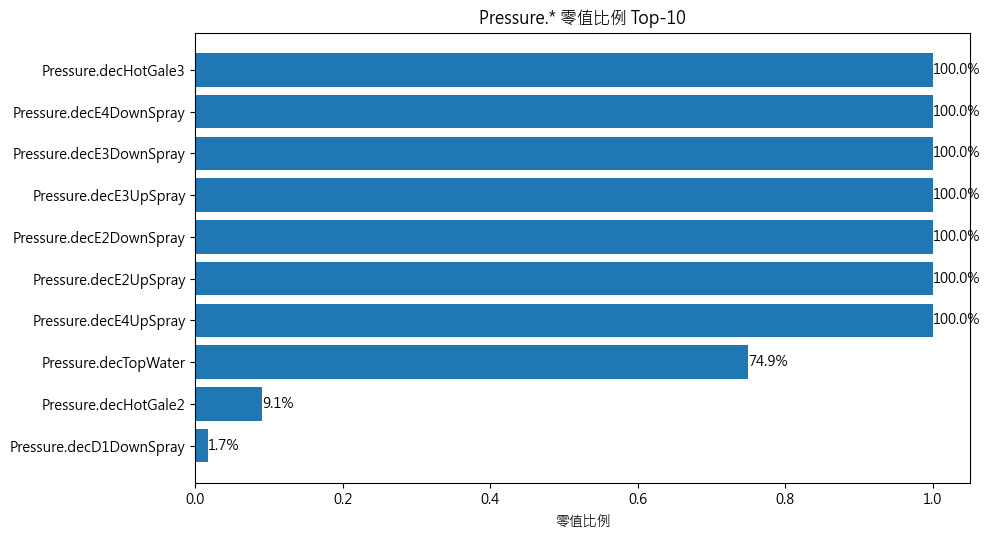

C:\Users\Sandy\AppData\Local\Temp\ipykernel_35740\2279786833.py:199: UserWarning: Glyph 8776 (\N{ALMOST EQUAL TO}) missing from font(s) Microsoft JhengHei.
  plt.xlabel("時間"); plt.ylabel("壓力"); plt.legend(loc="best"); plt.tight_layout(); plt.show()
d:\Sandy\科定\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8776 (\N{ALMOST EQUAL TO}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


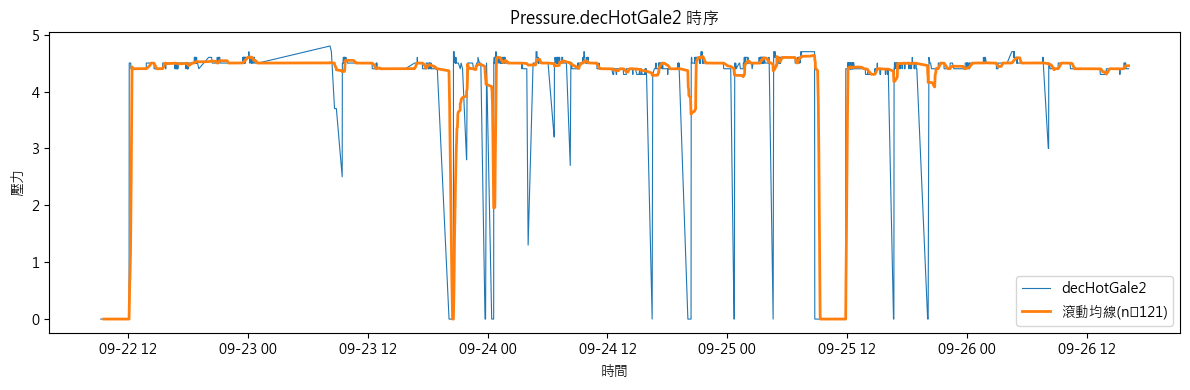

In [3]:
# pressure_qc_plots_functions.py
import pandas as pd, numpy as np, json, ast, re
import matplotlib
import matplotlib.pyplot as plt

# ===== 路徑設定（修改成你的檔案）=====
SRC=r"D:\Sandy\科定\data-1758877864792.csv"   # 也可放 kd_clean.csv
TSCOL="create_date"                           # 時間欄位名稱

# ===== 字體設定（避免中文亂碼）=====
matplotlib.rcParams['font.sans-serif']=['Microsoft JhengHei','Microsoft YaHei','SimHei','PMingLiU','Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus']=False

# ---------- 基礎工具 ----------
def _pjson(s):
    if pd.isna(s): return {}
    if isinstance(s,dict): return s
    t=str(s).strip()
    if not t or t.lower() in ("nan","none","null"): return {}
    try: return json.loads(t)
    except:
        try:
            v=ast.literal_eval(t)
            return v if isinstance(v,dict) else {}
        except: return {}

def _shift_of(h):
    if 8<=h<=15:return "DAY(08-15)"
    if 16<=h<=23:return "EVE(16-23)"
    return "NIGHT(00-07)"

def load_pressure_df(src=SRC,tscol=TSCOL):
    raw=pd.read_csv(src,low_memory=False)
    # 若已攤平則直接用；否則從 json_data 攤平
    if any(isinstance(c,str) and c.startswith("Pressure.") for c in raw.columns):
        df=raw.copy()
    else:
        j=pd.json_normalize(raw["json_data"].dropna().apply(_pjson),sep=".")
        df=j.copy()
    pressure_cols=[c for c in df.columns if isinstance(c,str) and c.startswith("Pressure.")]
    if not pressure_cols: raise SystemExit("找不到 Pressure.* 欄位")
    df[pressure_cols]=df[pressure_cols].apply(pd.to_numeric,errors="coerce")
    # 加時間
    if tscol in raw.columns:
        df["ts"]=pd.to_datetime(raw.loc[df.index,tscol],errors="coerce")
    else:
        df["ts"]=pd.NaT
    df=df.dropna(subset=["ts"]).sort_values("ts").reset_index(drop=True)
    df["date"]=df["ts"].dt.date
    df["hour"]=df["ts"].dt.hour
    df["shift"]=df["hour"].map(_shift_of)
    return df,pressure_cols

def get_updown_pairs(cols):
    pairs=[]
    for c in cols:
        if c.endswith("UpSpray"):
            base=c[:-7]
            d=base+"DownSpray"
            if d in cols: pairs.append((c,d))
    return sorted(set(pairs))

def pair_stats_df(df,pairs):
    rows=[]
    for up,down in pairs:
        sub=df[[up,down]].dropna()
        if len(sub)<100 or sub[[up,down]].std().sum()==0:
            continue
        r=float(sub.corr().iloc[0,1])
        ratio=(sub[up]+1e-6)/(sub[down]+1e-6)
        rows.append({
            "pair":f"{up} / {down}",
            "up":up,"down":down,
            "r":r,
            "median":float(ratio.median()),
            "q10":float(ratio.quantile(0.10)),
            "q90":float(ratio.quantile(0.90)),
            "oor":((ratio<0.8)|(ratio>1.25)).mean() # out-of-range
        })
    return pd.DataFrame(rows).sort_values("r")

# ---------- 圖表函式（各自獨立呼叫） ----------

def plot_zero_ratio_topk(k=20):
    """各 Pressure 欄位「0 值比例」Top-K（快速抓壞點/沒接線/近常數）"""
    df,cols=load_pressure_df()
    zeros=(df[cols]==0).sum()/len(df)
    top=zeros.sort_values(ascending=False).head(k)
    plt.figure(figsize=(10,0.45*len(top)+1))
    plt.barh(top.index, top.values)
    plt.gca().invert_yaxis()
    plt.xlabel("零值比例")
    plt.title(f"Pressure.* 零值比例 Top-{k}")
    for i,(y,v) in enumerate(zip(top.index,top.values)):
        plt.text(v, i, f"{v*100:.1f}%", va="center", ha="left")
    plt.tight_layout()
    plt.show()

def plot_hourly_imbalance_rate():
    """彙整全部 Up/Down 配對，計算每小時『失衡事件率』(比值<0.8或>1.25)"""
    df,cols=load_pressure_df()
    pairs=get_updown_pairs(cols)
    if not pairs:
        print("無有效 Up/Down 配對。");return
    evt_cols=[]
    for up,down in pairs:
        sub=df[[up,down]].dropna()
        if len(sub)<10 or sub[[up,down]].std().sum()==0: continue
        ratio=(df[up]+1e-6)/(df[down]+1e-6)
        df[f"evt_{up.split('.')[-1]}"]=((ratio<0.8)|(ratio>1.25)).astype(int)
        evt_cols.append(f"evt_{up.split('.')[-1]}")
    if not evt_cols:
        print("配對存在但有效樣本不足。");return
    df["evt_any"]=(df[evt_cols].sum(axis=1)>0).astype(int)
    by_hour=df.groupby("hour")["evt_any"].mean()
    plt.figure(figsize=(9,4))
    plt.bar(by_hour.index, by_hour.values)
    for h in by_hour.index:
        plt.text(h, by_hour.loc[h], f"{by_hour.loc[h]*100:.1f}%", ha="center", va="bottom")
    plt.title("Up/Down 失衡事件率（每小時）")
    plt.xlabel("小時(0-23)")
    plt.ylabel("事件率")
    plt.tight_layout()
    plt.show()

def plot_daily_ratio_trend(top_n=3):
    """挑 r 最低的 top_n 組配對，畫『每日中位 Up/Down 比值』趨勢（看長期飄移/換液影響）"""
    df,cols=load_pressure_df()
    pairs=get_updown_pairs(cols)
    stats=pair_stats_df(df,pairs)
    if stats.empty:
        print("無可用配對統計。");return
    for _,row in stats.head(top_n).iterrows():
        up,down=row["up"],row["down"]
        ratio=(df[up]+1e-6)/(df[down]+1e-6)
        day_med=ratio.groupby(df["date"]).median()
        base=float(ratio.median())
        plt.figure(figsize=(10,4))
        plt.plot(day_med.index, day_med.values, marker="o", linewidth=1.5)
        plt.axhline(base, linestyle="--", label=f"全期中位={base:.2f}")
        plt.title(f"每日中位 Up/Down 比值：{up.split('.')[-1]} / {down.split('.')[-1]}（r={row['r']:.3f}）")
        plt.xlabel("日期");plt.ylabel("比值（理想≈1）")
        plt.legend(loc="best");plt.tight_layout();plt.show()

def plot_updown_scatter(top_n=3):
    """挑 r 最低的 top_n 組配對，畫 Up vs Down 散點＋45°線（看同步性/離群）"""
    df,cols=load_pressure_df()
    pairs=get_updown_pairs(cols)
    stats=pair_stats_df(df,pairs)
    if stats.empty:
        print("無可用配對統計。");return
    for _,row in stats.head(top_n).iterrows():
        up,down=row["up"],row["down"]
        sub=df[[up,down]].dropna()
        if len(sub)<100: continue
        plt.figure(figsize=(6,6))
        plt.scatter(sub[down], sub[up], s=6, alpha=0.5)
        mn=min(sub.min()); mx=max(sub.max())
        plt.plot([mn,mx],[mn,mx], linestyle="--")
        plt.title(f"{up.split('.')[-1]} vs {down.split('.')[-1]}（r={row['r']:.3f}）")
        plt.xlabel(down); plt.ylabel(up); plt.tight_layout(); plt.show()

def plot_e1_ab_scatter():
    """E1 A/B Up 與 Down 的散點＋45°線（看左右支路同步性）"""
    df,cols=load_pressure_df()
    def _scatter(a,b,title):
        if a in cols and b in cols:
            sub=df[[a,b]].dropna()
            if len(sub)>100:
                plt.figure(figsize=(6,6))
                plt.scatter(sub[b], sub[a], s=6, alpha=0.5)
                mn=min(sub.min()); mx=max(sub.max())
                plt.plot([mn,mx],[mn,mx], linestyle="--")
                r=sub.corr().iloc[0,1]
                plt.title(f"{title}（r={r:.3f}）")
                plt.xlabel(b); plt.ylabel(a); plt.tight_layout(); plt.show()
            else:
                print(f"{title} 樣本不足")
        else:
            print(f"{title} 欄位不存在")
    _scatter("Pressure.decE1AUpSpray","Pressure.decE1BUpSpray","E1 A/B Up")
    _scatter("Pressure.decE1ADownSpray","Pressure.decE1BDownSpray","E1 A/B Down")

def plot_signal_timeseries(col="Pressure.decHotGale2"):
    """單一壓力訊號時序＋滾動均線（找間歇 0 值、尖峰）"""
    df,cols=load_pressure_df()
    if col not in cols:
        print(f"找不到欄位：{col}");return
    s=df[col].dropna()
    if len(s)<10:
        print("樣本不足");return
    # 簡易平滑：依資料長度自動估 n
    n=max(5, int(round(len(s)/200)))
    roll=s.rolling(n,min_periods=max(3,n//4)).mean()
    plt.figure(figsize=(12,4))
    plt.plot(df.loc[s.index,"ts"], s.values, linewidth=0.8, label=col.split('.')[-1])
    plt.plot(df.loc[s.index,"ts"], roll.values, linewidth=2, label=f"滾動均線(n≈{n})")
    plt.title(f"{col} 時序")
    plt.xlabel("時間"); plt.ylabel("壓力"); plt.legend(loc="best"); plt.tight_layout(); plt.show()

def plot_signal_hourly_zero(col="Pressure.decHotGale2"):
    """單一壓力訊號『每小時 0 值比例』柱狀圖（找特定時段掉點/停開）"""
    df,cols=load_pressure_df()
    if col not in cols:
        print(f"找不到欄位：{col}");return
    z0=(df[col]==0).astype(int)
    by_hour=(z0.groupby(df["hour"]).mean())
    plt.figure(figsize=(9,4))
    plt.bar(by_hour.index, by_hour.values)
    for h in by_hour.index:
        plt.text(h, by_hour.loc[h], f"{by_hour.loc[h]*100:.1f}%", ha="center", va="bottom")
    plt.title(f"{col} 0 值比例（每小時）")
    plt.xlabel("小時(0-23)"); plt.ylabel("0 值比例")
    plt.tight_layout(); plt.show()

# ======== 使用範例（請自行解除註解呼叫你需要的圖）========
plot_zero_ratio_topk(10)
#plot_hourly_imbalance_rate()
#plot_daily_ratio_trend(top_n=3)
#plot_updown_scatter(top_n=3)
#plot_e1_ab_scatter()
plot_signal_timeseries("Pressure.decHotGale2")
#plot_signal_hourly_zero("Pressure.decHotGale2")

=== 穩態掉壓（CMD ON & PRESS=0）統計 ===
總筆數=24131；掉壓筆數=2170；占比=9.0%
估計取樣間隔≈8.1s/筆；掉壓總時長≈294.4 分鐘

--- 掉壓事件（連續≥3筆）Top 10（依筆數長度）---
                     start_ts                     end_ts     n     dur_min
1  2025-09-22 09:16:29.988117 2025-09-22 12:06:20.716473  1050  142.459826
11 2025-09-25 08:44:40.467865 2025-09-25 11:50:42.614188   876  118.852198
3  2025-09-23 20:07:44.812911 2025-09-23 20:34:20.375332   151   20.487080
5  2025-09-24 00:24:13.404647 2025-09-24 00:36:18.135595    59    8.004885
7  2025-09-24 20:02:21.167981 2025-09-24 20:21:52.606332    22    2.984873
13 2025-09-25 20:02:22.860533 2025-09-25 20:05:59.951338     9    1.221084
9  2025-09-25 04:34:33.759959 2025-09-25 04:34:57.670430     3    0.407028


=== 三支路狀態分布（全期間）===
000(全關): 0.1%
100(H1): 9.0%
110(H1,H2): 90.9%

=== HotGale2 掉壓期間（cmd_on 且 h2_on=0）之狀態分布 ===
000(全關): 0.1%
100(H1): 99.9%

HotGale2 掉壓佔比：9.0%（只在 cmd_on 期間計）


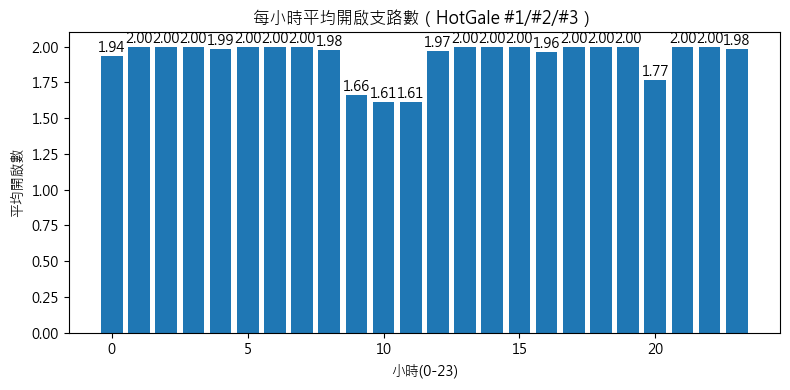

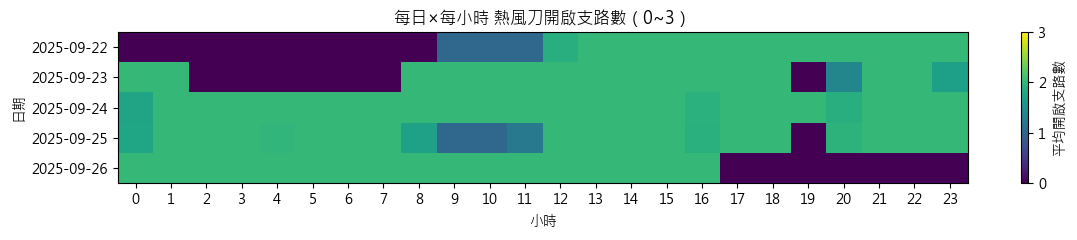

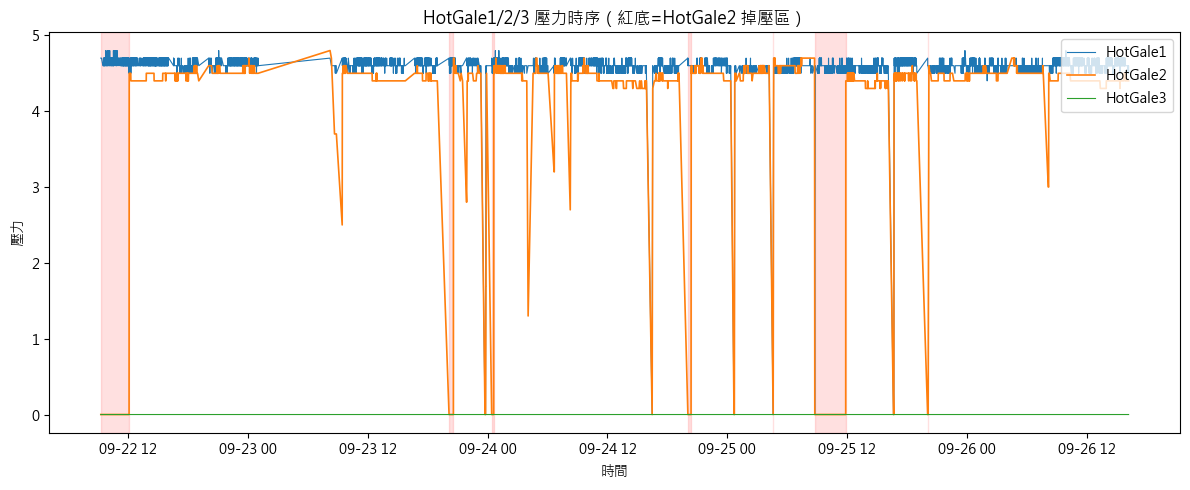

In [9]:
# hotgale_state_analysis.py
import pandas as pd, numpy as np, json, ast, matplotlib, matplotlib.pyplot as plt

SRC=r"D:\Sandy\科定\data-1758877864792.csv"
TSCOL="create_date"
FREQ="Frequency.decHotGale"
H1="Pressure.decHotGale1";H2="Pressure.decHotGale2";H3="Pressure.decHotGale3"
TH=0.05     # 壓力>TH 視為 ON
MIN_CONSEC=3

matplotlib.rcParams['font.sans-serif']=['Microsoft JhengHei','Microsoft YaHei','SimHei','PMingLiU','Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus']=False

def pjson(s):
    if pd.isna(s):return{}
    if isinstance(s,dict):return s
    t=str(s).strip()
    if(not t)or(t.lower()in("nan","none","null")):return{}
    try:return json.loads(t)
    except:
        try:v=ast.literal_eval(t);return v if isinstance(v,dict)else{}
        except:return{}

def load_df():
    raw=pd.read_csv(SRC,low_memory=False)
    if any(isinstance(c,str)and c.startswith(("Pressure.","Frequency.")) for c in raw.columns):
        wide=raw.copy()
    else:
        j=pd.json_normalize(raw["json_data"].dropna().apply(pjson),sep=".");wide=j
    ts=pd.to_datetime(raw.loc[wide.index,TSCOL],errors="coerce") if TSCOL in raw.columns else pd.NaT
    keep=["ts",FREQ,H1,H2,H3]
    df=wide.assign(ts=ts)[keep].dropna(subset=["ts"]).sort_values("ts").reset_index(drop=True)
    for c in[H1,H2,H3,FREQ]:df[c]=pd.to_numeric(df[c],errors="coerce")
    df=df.dropna(subset=[H1,H2,H3])
    return df

def add_state(df):
    df=df.copy()
    df["cmd_on"]=(df[FREQ]>0)
    df["h1_on"]=(df[H1]>TH);df["h2_on"]=(df[H2]>TH);df["h3_on"]=(df[H3]>TH)
    df["state_bits"]=df["h1_on"].astype(int)*4+df["h2_on"].astype(int)*2+df["h3_on"].astype(int) # 0..7
    df["num_on"]=df[["h1_on","h2_on","h3_on"]].sum(axis=1)
    df["hour"]=df["ts"].dt.hour;df["date"]=df["ts"].dt.date
    return df

def print_state_summary(df):
    print("=== 三支路狀態分布（全期間）===")
    mapname={0:"000(全關)",1:"001(H3)",2:"010(H2)",3:"011(H2,H3)",4:"100(H1)",
             5:"101(H1,H3)",6:"110(H1,H2)",7:"111(H1,H2,H3)"}
    s=df["state_bits"].value_counts(normalize=True).sort_index()
    for code,p in s.items():
        print(f"{mapname.get(code,str(code))}: {p*100:.1f}%")
    print("\n=== HotGale2 掉壓期間（cmd_on 且 h2_on=0）之狀態分布 ===")
    mask=(df["cmd_on"] & (~df["h2_on"]))
    s2=df.loc[mask,"state_bits"].value_counts(normalize=True).sort_index()
    for code,p in s2.items():
        print(f"{mapname.get(code,str(code))}: {p*100:.1f}%")
    print(f"\nHotGale2 掉壓佔比：{mask.mean()*100:.1f}%（只在 cmd_on 期間計）")

def plot_num_on_by_hour(df):
    r=df.groupby("hour")["num_on"].mean()
    plt.figure(figsize=(8,4));plt.bar(r.index,r.values)
    for h in r.index:plt.text(h,r.loc[h],f"{r.loc[h]:.2f}",ha="center",va="bottom")
    plt.title("每小時平均開啟支路數（HotGale #1/#2/#3）");plt.xlabel("小時(0-23)");plt.ylabel("平均開啟數")
    plt.tight_layout();plt.show()

def plot_state_heatmap(df):
    # 每小時每日期的 num_on 熱圖（0~3）
    piv=(df.groupby(["date","hour"])["num_on"].mean().unstack("hour").fillna(0))
    plt.figure(figsize=(12,0.5+0.4*len(piv)))
    im=plt.imshow(piv.values,aspect="auto",origin="upper",vmin=0,vmax=3)
    plt.colorbar(im,label="平均開啟支路數")
    plt.xticks(ticks=np.arange(0,24),labels=[str(h)for h in range(24)])
    plt.yticks(ticks=np.arange(len(piv.index)),labels=[str(d)for d in piv.index])
    plt.title("每日×每小時 熱風刀開啟支路數（0~3）")
    plt.xlabel("小時");plt.ylabel("日期");plt.tight_layout();plt.show()

def plot_overlay(df):
    # 三支路壓力疊圖，並以紅底標 #2 掉壓區
    drop2=(df["cmd_on"]&(~df["h2_on"]))
    plt.figure(figsize=(12,5))
    plt.plot(df["ts"],df[H1],label="HotGale1",linewidth=0.8)
    plt.plot(df["ts"],df[H2],label="HotGale2",linewidth=1.2)
    plt.plot(df["ts"],df[H3],label="HotGale3",linewidth=0.8)
    state=drop2.values;tsv=df["ts"].values
    def paint(s,e):plt.axvspan(tsv[s],tsv[e-1],color="red",alpha=0.12)
    s=0
    for i in range(1,len(state)):
        if state[i]!=state[s]:
            if state[s]:paint(s,i)
            s=i
    if state[s]:paint(s,len(state))
    plt.title("HotGale1/2/3 壓力時序（紅底=HotGale2 掉壓區）");plt.xlabel("時間");plt.ylabel("壓力")
    plt.legend(loc="upper right");plt.tight_layout();plt.show()

# 使用方式：
df=load_df(); df=add_state(df)
print_state_summary(df)
plot_num_on_by_hour(df)
plot_state_heatmap(df)
plot_overlay(df)




=== 時間紀錄（log軸）摘要 ===
主採樣間隔 ≈ 4.10s；容差帶 [3.60,4.60]s；落帶比例=25.7%
短缺口(>容差且≤60s)：16037 筆
長斷檔(>60s)：431 筆；最大=25897.9s

--- 長斷檔 Top ---
                  start_ts      gap_sec  gap_min
2025-09-23 08:13:08.121417 25897.923728   431.63
2025-09-23 20:07:44.812911  4200.246578    70.00
2025-09-25 20:02:22.860533  3868.868948    64.48
2025-09-22 20:03:44.041768  3517.017297    58.62
2025-09-23 16:39:54.562454  3259.429461    54.32
2025-09-24 20:02:21.167981  3112.904690    51.88
2025-09-25 08:14:24.053367  2749.741143    45.83
2025-09-24 06:38:48.595313  2149.810429    35.83


C:\Users\Sandy\AppData\Local\Temp\ipykernel_35740\1563926879.py:92: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout(); plt.show()
d:\Sandy\科定\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8804 (\N{LESS-THAN OR EQUAL TO}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


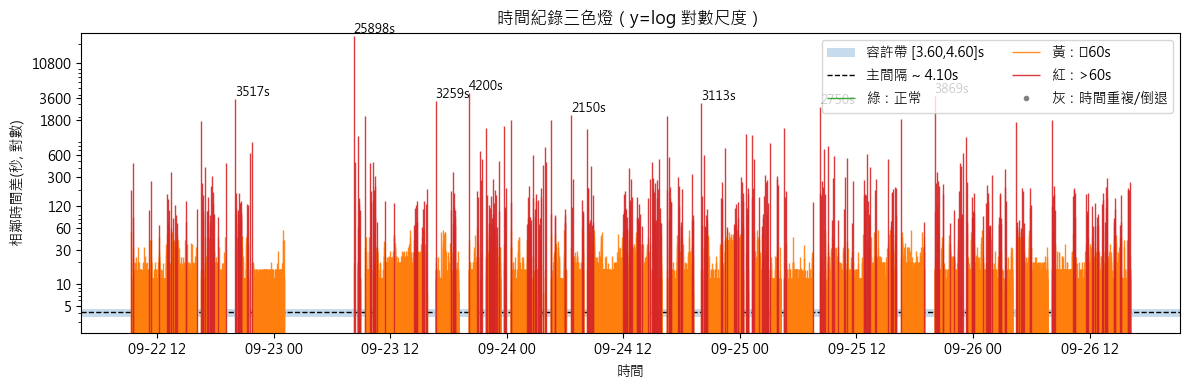

In [21]:
# time_gaps_logscale.py
import pandas as pd, numpy as np, matplotlib, matplotlib.pyplot as plt

# === 檔案與欄位 ===
SRC=r"D:\Sandy\科定\data-1758877864792.csv"
TS_CAND=["create_date","timestamp","time","CreateTime","CreateDate"]

# === 參數（可調）===
ROUND_RES=0.1         # 主間隔估計的取整解析度(秒)
REL_TOL=0.05          # 主間隔相對容差 ±5%
ABS_TOL=0.5           # 主間隔絕對容差 ±0.5秒（兩者取較大）
SMALL_GAP_MAX=60.0    # 短缺口上限(秒)：(容差上界, ≤此值) → 黃
RED_GAP_MIN=60.0      # 長斷檔下限(秒)：>此值 → 紅
TOP_ANN=8             # 圖上標註的紅色事件數
YMIN_FLOOR=0.1        # log軸最小y（>0）
FONT=['Microsoft JhengHei','Microsoft YaHei','SimHei','PMingLiU','Arial Unicode MS']
matplotlib.rcParams['font.sans-serif']=FONT; matplotlib.rcParams['axes.unicode_minus']=False

# === 讀取時間 ===
raw=pd.read_csv(SRC,low_memory=False)
ts_col=next((c for c in TS_CAND if c in raw.columns),None)
if ts_col is None: raise SystemExit(f"找不到時間欄位：{TS_CAND}")
df=(pd.DataFrame({"ts":pd.to_datetime(raw[ts_col],errors="coerce")})
      .dropna().sort_values("ts").reset_index(drop=True))
if len(df)<3: raise SystemExit("有效時間筆數不足。")

# 相鄰時間差(秒)；差值對應到第二筆的時間
dt=df["ts"].diff().dt.total_seconds()
t2=df["ts"].iloc[1:].reset_index(drop=True)
dt=dt.iloc[1:].reset_index(drop=True)

# 主間隔與容差帶
dt_pos=dt[dt>0]
if dt_pos.empty: raise SystemExit("相鄰差皆<=0，時間欄位可能有問題。")
dt_round=(dt_pos/ROUND_RES).round()*ROUND_RES
mode=float(dt_round.mode().iloc[0])
tol=max(ABS_TOL,mode*REL_TOL)
lo,hi=mode-tol,mode+tol
uniform_ratio=float(dt_pos.between(lo,hi).mean())

# 三色分類
mask_green=dt.between(lo,hi)
mask_yellow=(dt>hi)&(dt<=SMALL_GAP_MAX)
mask_red=(dt>RED_GAP_MIN)
mask_gray=(dt<=0)  # 重複/倒退時間

# 紅色事件表
red_df=pd.DataFrame({"start_ts":t2[mask_red].values,"gap_sec":dt[mask_red].values})\
        .sort_values("gap_sec",ascending=False).reset_index(drop=True)

print("=== 時間紀錄（log軸）摘要 ===")
print(f"主採樣間隔 ≈ {mode:.2f}s；容差帶 [{lo:.2f},{hi:.2f}]s；落帶比例={uniform_ratio*100:.1f}%")
print(f"短缺口(>容差且≤{SMALL_GAP_MAX:.0f}s)：{int(mask_yellow.sum())} 筆")
print(f"長斷檔(>{RED_GAP_MIN:.0f}s)：{int(mask_red.sum())} 筆；最大={dt[mask_red].max():.1f}s")
if not red_df.empty:
    tmp=red_df.head(TOP_ANN).copy(); tmp["gap_min"]=(tmp["gap_sec"]/60).round(2)
    print("\n--- 長斷檔 Top ---"); print(tmp.to_string(index=False))

# === 繪圖（y=log）===
fig,ax=plt.subplots(figsize=(12,4))
# 參考帶與主間隔線
ax.axhspan(lo,hi,alpha=0.25,label=f"容許帶 [{lo:.2f},{hi:.2f}]s")
ax.axhline(mode,linestyle="--",color="k",linewidth=1.0,label=f"主間隔 ~ {mode:.2f}s")

def draw(mask,color,label):
    if mask.any():
        ax.vlines(t2[mask],YMIN_FLOOR,dt[mask],colors=color,alpha=0.9,linewidth=1.0,label=label)

draw(mask_green,"#2ca02c","綠：正常")
draw(mask_yellow,"#ff7f0e",f"黃：≤{SMALL_GAP_MAX:.0f}s")
draw(mask_red,"#d62728",f"紅：>{RED_GAP_MIN:.0f}s")
# 灰（<=0s）用小點放在最小y
if mask_gray.any():
    ax.plot(t2[mask_gray],[YMIN_FLOOR]*mask_gray.sum(),".",color="0.5",label="灰：時間重複/倒退")

# 標註Top紅色事件
for _,r in red_df.head(TOP_ANN).iterrows():
    ax.text(r["start_ts"],r["gap_sec"],f"{int(round(r['gap_sec']))}s",ha="left",va="bottom",fontsize=9)

# y 軸對數
ax.set_yscale("log")
ymin=max(YMIN_FLOOR,lo*0.6); ymax=max(dt.max()*1.1,RED_GAP_MIN*1.2)
ax.set_ylim(ymin,ymax)

# 友善的log刻度（自動挑在範圍內）
ticks=[0.1,0.2,0.5,1,2,5,10,30,60,120,300,600,1800,3600,10800,28800]
ticks=[t for t in ticks if ymin<=t<=ymax]
ax.set_yticks(ticks); ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_title("時間紀錄三色燈（y=log 對數尺度）")
ax.set_xlabel("時間"); ax.set_ylabel("相鄰時間差(秒, 對數)")
ax.legend(loc="upper right",ncol=2)
plt.tight_layout(); plt.show()


In [22]:
import pandas as pd, numpy as np, json, ast, matplotlib.pyplot as plt

# === 1) 讀檔 + 展開 json ===
SRC = r"D:\Sandy\科定\data-1758877864792.csv"
CP_COLS = [
 "ConstantPressure.decD1","ConstantPressure.decD2",
 "ConstantPressure.decE1A","ConstantPressure.decE1B",
 "ConstantPressure.decE2Up","ConstantPressure.decE2Down",
 "ConstantPressure.decE3Up","ConstantPressure.decE3Down",
 "ConstantPressure.decE4Up","ConstantPressure.decE4Down",
 "ConstantPressure.decS1","ConstantPressure.decS2"
]
TSCOL = "create_date"

def pjson(s):
    if pd.isna(s): return {}
    if isinstance(s,dict): return s
    t=str(s).strip()
    if not t or t.lower() in ("nan","none","null"): return {}
    try: return json.loads(t)
    except: 
        try:
            v=ast.literal_eval(t); return v if isinstance(v,dict) else {}
        except: return {}

raw = pd.read_csv(SRC, low_memory=False)
j = pd.json_normalize(raw["json_data"].dropna().apply(pjson), sep=".")
if not set(CP_COLS).issubset(j.columns):
    missing = [c for c in CP_COLS if c not in j.columns]
    raise SystemExit(f"找不到欄位：{missing}")

df = j[CP_COLS].apply(pd.to_numeric, errors="coerce").copy()
df["ts"] = pd.to_datetime(raw.loc[j.index, TSCOL], errors="coerce")

# 哨兵值 → NaN（常見 0xFFFF×0.1）
for c in CP_COLS:
    df.loc[df[c]>=6553.4, c] = np.nan

# === 2) 基本檢核 ===
# 2.1 概要
desc = df[CP_COLS].describe().T
print("=== 基本統計(已過濾6553.x) ===")
print(desc[["count","mean","std","min","25%","50%","75%","max"]].round(3))

# 2.2 0 值比例（整體 / 每小時）
print("\n=== 0 值比例(整體) ===")
zero_all = (df[CP_COLS]==0).mean().sort_values(ascending=False)
print((zero_all*100).round(2).astype(str)+"%")

print("\n=== 0 值比例(每小時) 只列>10%的 ===")
hour = df.dropna(subset=["ts"]).copy()
hour["hour"] = hour["ts"].dt.hour
over10 = {}
for c in CP_COLS:
    r = hour.groupby("hour")[c].apply(lambda s: (s==0).mean())
    r = r[r>0.10]
    if len(r): over10[c] = r.round(3).to_dict()
print(over10 if over10 else "（無>10% 小時別 0 值）")

# 2.3 相關性（雙路/上下）
pairs = [
 ("ConstantPressure.decE1A","ConstantPressure.decE1B"),
 ("ConstantPressure.decE2Up","ConstantPressure.decE2Down"),
 ("ConstantPressure.decE3Up","ConstantPressure.decE3Down"),
 ("ConstantPressure.decE4Up","ConstantPressure.decE4Down"),
 ("ConstantPressure.decS1","ConstantPressure.decS2"),
 ("ConstantPressure.decD1","ConstantPressure.decD2"),
]
def corr(a,b):
    return df[[a,b]].corr().iloc[0,1]
print("\n=== 成對相關（剔除哨兵值後）===")
for a,b in pairs:
    print(f"{a} vs {b}: r={corr(a,b):.3f}")

# 2.4 上/下比值（E2~E4）
def ratio_stats(up,down):
    r = (df[up]/df[down]).replace([np.inf,-np.inf], np.nan).dropna()
    med = r.median()
    low = (r<0.8).mean()*100
    high = (r>1.25).mean()*100
    return med,low,high
print("\n=== Up/Down 比值（中位數；越接近1越平衡）===")
for stage in ["E2","E3","E4"]:
    up=f"ConstantPressure.dec{stage}Up"; down=f"ConstantPressure.dec{stage}Down"
    med,low,high = ratio_stats(up,down)
    print(f"{stage}: median={med:.2f} | <0.8={low:.2f}% | >1.25={high:.2f}%")

# === 3) 單張圖函式（挑「看得出異常」的） ===
def plot_zero_heatmap():
    """各欄位 × 小時 的 0 值比例（高亮規律性停機/待機）"""
    g = hour.groupby("hour")[CP_COLS].apply(lambda x:(x==0).mean())
    plt.figure(figsize=(10,6))
    im=plt.imshow(g.values.T, aspect="auto", origin="lower", vmin=0, vmax=g.values.max())
    plt.colorbar(im,label="0 值比例")
    plt.yticks(range(len(CP_COLS)), CP_COLS)
    plt.xticks(range(24), range(24))
    plt.title("ConstantPressure 各欄位 × 小時 的 0 值比例")
    plt.xlabel("小時(0-23)"); plt.ylabel("欄位")
    plt.tight_layout(); plt.show()

def plot_pair_timeseries(stage="E2"):
    """看某一站 Up vs Down（或 E1A vs E1B）的時間序列 + 1h 滾動平均"""
    if stage=="E1":
        a,b="ConstantPressure.decE1A","ConstantPressure.decE1B"
        ttl="E1 A/B"
    else:
        a,b=f"ConstantPressure.dec{stage}Up", f"ConstantPressure.dec{stage}Down"
        ttl=f"{stage} Up/Down"
    sub = df.dropna(subset=["ts",a,b]).sort_values("ts")
    n = max(5, int(round(3600/ max(1, sub["ts"].diff().dt.total_seconds().median() or 8))))
    plt.figure(figsize=(12,4))
    plt.plot(sub["ts"], sub[a], alpha=0.5, label=a)
    plt.plot(sub["ts"], sub[b], alpha=0.5, label=b)
    plt.plot(sub["ts"], sub[a].rolling(n,min_periods=n//4).mean(), lw=2, label=f"{a}~1hMA")
    plt.plot(sub["ts"], sub[b].rolling(n,min_periods=n//4).mean(), lw=2, label=f"{b}~1hMA")
    plt.title(f"ConstantPressure 時序：{ttl}")
    plt.xlabel("時間"); plt.ylabel("壓力(推估單位)")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_ratio_bars():
    """E2/E3/E4 的 Up/Down 中位數比值條圖（>1 代表上>下；抓偏壓）"""
    stages=["E2","E3","E4"]; meds=[]
    for st in stages:
        up,down=f"ConstantPressure.dec{st}Up",f"ConstantPressure.dec{st}Down"
        med=(df[up]/df[down]).replace([np.inf,-np.inf],np.nan).median()
        meds.append(med)
    plt.figure(figsize=(5,3))
    plt.bar(stages, meds)
    for i,v in enumerate(meds): plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
    plt.axhline(1.0, ls="--", color="grey"); plt.ylim(0.6,1.5)
    plt.title("Up/Down 中位數比值（>1=上>下）"); plt.ylabel("中位數比值")
    plt.tight_layout(); plt.show()

# === 範例呼叫（挑一兩張看重點就好） ===
# plot_zero_heatmap()
# plot_pair_timeseries("E2")   # 或 "E3"/"E4"/"E1"
# plot_ratio_bars()


=== 基本統計(已過濾6553.x) ===
                              count   mean    std  min  25%  50%  75%  max
ConstantPressure.decD1      24131.0  1.659  0.224  0.0  1.7  1.7  1.7  1.8
ConstantPressure.decD2      24131.0  1.671  0.216  0.0  1.7  1.7  1.7  1.9
ConstantPressure.decE1A     24130.0  2.951  0.379  0.0  3.0  3.0  3.0  3.0
ConstantPressure.decE1B     24130.0  2.954  0.365  0.0  3.0  3.0  3.0  3.0
ConstantPressure.decE2Up    24125.0  3.161  0.348  0.0  3.2  3.2  3.2  3.2
ConstantPressure.decE2Down  24127.0  2.558  0.326  0.0  2.6  2.6  2.6  2.8
ConstantPressure.decE3Up    24127.0  2.869  0.298  0.0  2.9  2.9  2.9  3.3
ConstantPressure.decE3Down  24127.0  2.462  0.306  0.0  2.5  2.5  2.5  3.2
ConstantPressure.decE4Up    24129.0  2.971  0.291  0.0  3.0  3.0  3.0  3.0
ConstantPressure.decE4Down  24129.0  2.465  0.294  0.0  2.5  2.5  2.5  2.5
ConstantPressure.decS1      24129.0  2.493  0.127  0.0  2.5  2.5  2.5  3.1
ConstantPressure.decS2      24130.0  2.493  0.123  0.0  2.5  2.5  2.5  2.5



C:\Users\Sandy\AppData\Local\Temp\ipykernel_35740\2050750508.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab=(df.groupby("TCW_bin")[["evt10","evt05"]].mean()
C:\Users\Sandy\AppData\Local\Temp\ipykernel_35740\2050750508.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n=df.groupby("TCW_bin").size().rename("n")


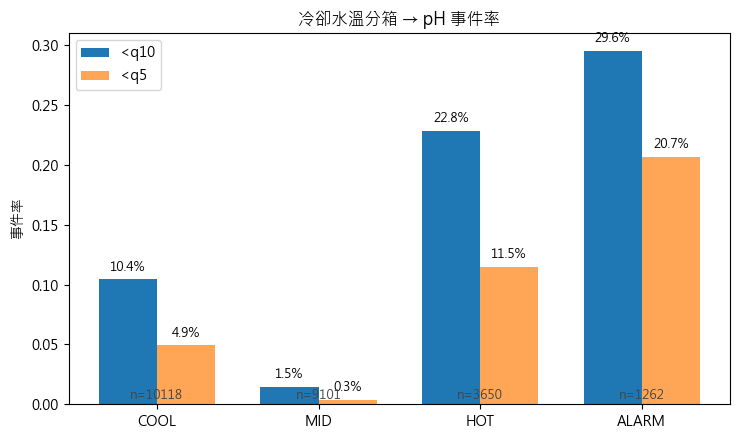

C:\Users\Sandy\AppData\Local\Temp\ipykernel_35740\2050750508.py:109: UserWarning: Glyph 8776 (\N{ALMOST EQUAL TO}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout(); plt.show()
d:\Sandy\科定\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8776 (\N{ALMOST EQUAL TO}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


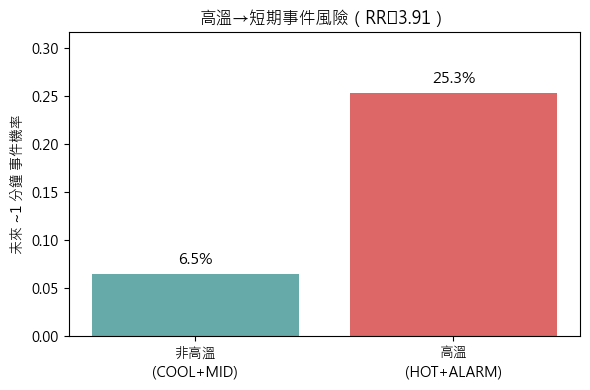

C:\Users\Sandy\AppData\Local\Temp\ipykernel_35740\2050750508.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab=(sub.groupby("TCW_bin")[["evt10","evt05"]].mean()
C:\Users\Sandy\AppData\Local\Temp\ipykernel_35740\2050750508.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  n=sub.groupby("TCW_bin").size().rename("n")


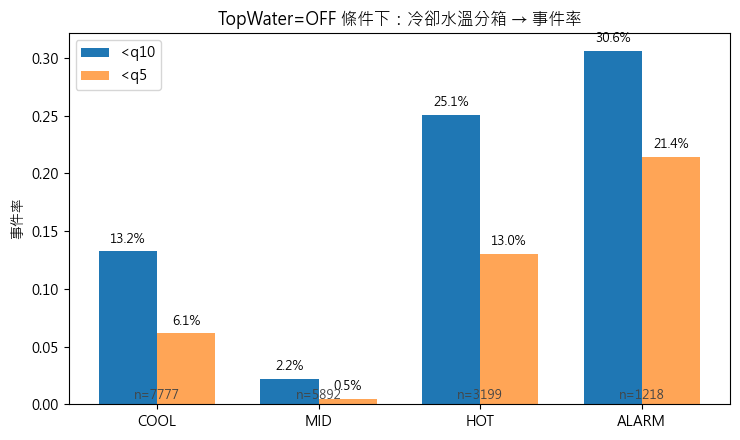

In [29]:
import pandas as pd, numpy as np, json, ast, matplotlib, matplotlib.pyplot as plt

# ===== 基本參數 =====
SRC=r"D:\Sandy\科定\data-1758877864792.csv"  # 你的檔案路徑
PH ="PH.decPressureRinse5"
TCW="Temperature.decCoolingWater"
TOP="Pressure.decTopWater"
TSCOL="create_date"

Q_MAIN=0.10     # 事件門檻：q10
Q_SEV =0.05     # 嚴重門檻：q5
TCW_BINS=[-1,16.0,17.5,18.5,99]
TCW_LABELS=["COOL","MID","HOT","ALARM"]
LAG_STEPS=8     # 約 ~1 分鐘（你資料的取樣間隔 ~8秒/筆）
CUT_DEFAULT=0.35

# 字型（顯示中文）
matplotlib.rcParams['font.sans-serif']=['Microsoft JhengHei','Microsoft YaHei','SimHei','PMingLiU','Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus']=False

def pjson(s):
    if pd.isna(s): return {}
    if isinstance(s,dict): return s
    t=str(s).strip()
    if (not t) or (t.lower() in ("nan","none","null")): return {}
    try: return json.loads(t)
    except:
        try:
            v=ast.literal_eval(t)
            return v if isinstance(v,dict) else {}
        except: return {}

# ===== 讀檔 + 展開 =====
raw=pd.read_csv(SRC,low_memory=False)
if TSCOL not in raw.columns: raise SystemExit(f"找不到時間欄位:{TSCOL}")
j=pd.json_normalize(raw["json_data"].dropna().apply(pjson),sep=".")

for c in (PH,TCW,TOP):
    if c not in j.columns: raise SystemExit(f"缺少欄位:{c}")
df=j[[PH,TCW,TOP]].apply(pd.to_numeric,errors="coerce").copy()
df["ts"]=pd.to_datetime(raw.loc[j.index,TSCOL],errors="coerce")
df=df.dropna(subset=["ts",PH,TCW]).sort_values("ts").reset_index(drop=True)

# ===== 門檻/分箱/事件 =====
th_main=float(df[PH].quantile(Q_MAIN))
th_sev =float(df[PH].quantile(Q_SEV))
df["evt10"]=(df[PH]<th_main).astype(int)
df["evt05"]=(df[PH]<th_sev ).astype(int)

df["TCW_bin"]=pd.cut(df[TCW],bins=TCW_BINS,labels=TCW_LABELS,include_lowest=True)

# TopWater 檔位 OFF/LOW/HIGH（和你前面一致）
vals=df[TOP].dropna()
cut_point=CUT_DEFAULT if (len(vals)>0 and vals.min()<=CUT_DEFAULT<=vals.max()) else float(vals.median()) if len(vals)>0 else CUT_DEFAULT
def bucket_top(x,cp=cut_point,eps=1e-9):
    if pd.isna(x): return "NA"
    x=float(x)
    if x<=0+eps: return "OFF"
    if x<=0.01+eps: return "LOW"
    return "LOW" if x<=cp+eps else "HIGH"
df["TopWater_bin"]=df[TOP].map(bucket_top)

# ===== (1) 圖：溫度分箱 → 事件率 =====
def plot_evt_by_tcw():
    tab=(df.groupby("TCW_bin")[["evt10","evt05"]].mean()
         .rename(columns={"evt10":"p(evt<q10)","evt05":"p(evt<q5)"}))
    n=df.groupby("TCW_bin").size().rename("n")
    out=pd.concat([tab,n],axis=1).reindex(TCW_LABELS)

    x=np.arange(len(out.index))
    w=0.36
    fig,ax=plt.subplots(figsize=(7.5,4.5))
    b1=ax.bar(x-w/2,out["p(evt<q10)"],width=w,label=f"<q{int(Q_MAIN*100)}")
    b2=ax.bar(x+w/2,out["p(evt<q5)"], width=w,label=f"<q{int(Q_SEV*100)}",alpha=0.7)

    for i,v in enumerate(out["p(evt<q10)"]):
        ax.text(i-w/2,v+0.005,f"{v:.1%}",ha="center",va="bottom",fontsize=9)
    for i,v in enumerate(out["p(evt<q5)"]):
        ax.text(i+w/2,v+0.005,f"{v:.1%}",ha="center",va="bottom",fontsize=9)
    for i,v in enumerate(out["n"]):
        ax.text(i,0.002,f"n={int(v)}",ha="center",va="bottom",fontsize=9,color="#444")

    ax.set_xticks(x,TCW_LABELS)
    ax.set_ylabel("事件率")
    ax.set_title("冷卻水溫分箱 → pH 事件率")
    ax.legend(loc="upper left")
    plt.tight_layout(); plt.show()

# ===== (2) 圖：高溫 vs 非高溫 → 未來 ~1 分鐘 事件風險（含 RR） =====
def plot_future_risk():
    # 未來K筆是否發生事件
    fwd=(df["evt10"].rolling(window=LAG_STEPS,min_periods=1).max().shift(-LAG_STEPS+1))
    df["evt10_nextK"]=fwd.fillna(0).astype(int)

    hotnow=df["TCW_bin"].isin(["HOT","ALARM"]).astype(int)
    risk_hi=float(df.loc[hotnow==1,"evt10_nextK"].mean())
    risk_lo=float(df.loc[hotnow==0,"evt10_nextK"].mean())
    rr=(risk_hi/risk_lo) if risk_lo>0 else np.nan

    fig,ax=plt.subplots(figsize=(6,4))
    xs=["非高溫\n(COOL+MID)","高溫\n(HOT+ALARM)"]
    ys=[risk_lo,risk_hi]
    ax.bar(xs,ys,color=["#6aa","#d66"])
    for i,v in enumerate(ys):
        ax.text(i,v+0.006,f"{v:.1%}",ha="center",va="bottom",fontsize=11)
    ax.set_ylim(0,max(ys)*1.25)
    ax.set_ylabel("未來 ~1 分鐘 事件機率")
    ax.set_title(f"高溫→短期事件風險（RR≈{rr:.2f}）")
    plt.tight_layout(); plt.show()

# ===== (3) 圖：在 TopWater=OFF 條件下，溫度分箱 → 事件率 =====
def plot_off_stratified():
    sub=df[df["TopWater_bin"]=="OFF"].copy()
    if sub.empty:
        print("TopWater=OFF 無資料"); return
    tab=(sub.groupby("TCW_bin")[["evt10","evt05"]].mean()
         .rename(columns={"evt10":"p(evt<q10)","evt05":"p(evt<q5)"}))
    n=sub.groupby("TCW_bin").size().rename("n")
    out=pd.concat([tab,n],axis=1).reindex(TCW_LABELS)

    x=np.arange(len(out.index)); w=0.36
    fig,ax=plt.subplots(figsize=(7.5,4.5))
    b1=ax.bar(x-w/2,out["p(evt<q10)"],width=w,label=f"<q{int(Q_MAIN*100)}")
    b2=ax.bar(x+w/2,out["p(evt<q5)"], width=w,label=f"<q{int(Q_SEV*100)}",alpha=0.7)
    for i,v in enumerate(out["p(evt<q10)"]):
        ax.text(i-w/2,v+0.005,f"{v:.1%}",ha="center",va="bottom",fontsize=9)
    for i,v in enumerate(out["p(evt<q5)"]):
        ax.text(i+w/2,v+0.005,f"{v:.1%}",ha="center",va="bottom",fontsize=9)
    for i,v in enumerate(out["n"]):
        ax.text(i,0.002,f"n={int(v)}",ha="center",va="bottom",fontsize=9,color="#444")

    ax.set_xticks(x,TCW_LABELS)
    ax.set_ylabel("事件率")
    ax.set_title("TopWater=OFF 條件下：冷卻水溫分箱 → 事件率")
    ax.legend(loc="upper left")
    plt.tight_layout(); plt.show()

# ===== 執行（想看哪些就呼叫哪些）=====
plot_evt_by_tcw()
plot_future_risk()
plot_off_stratified()


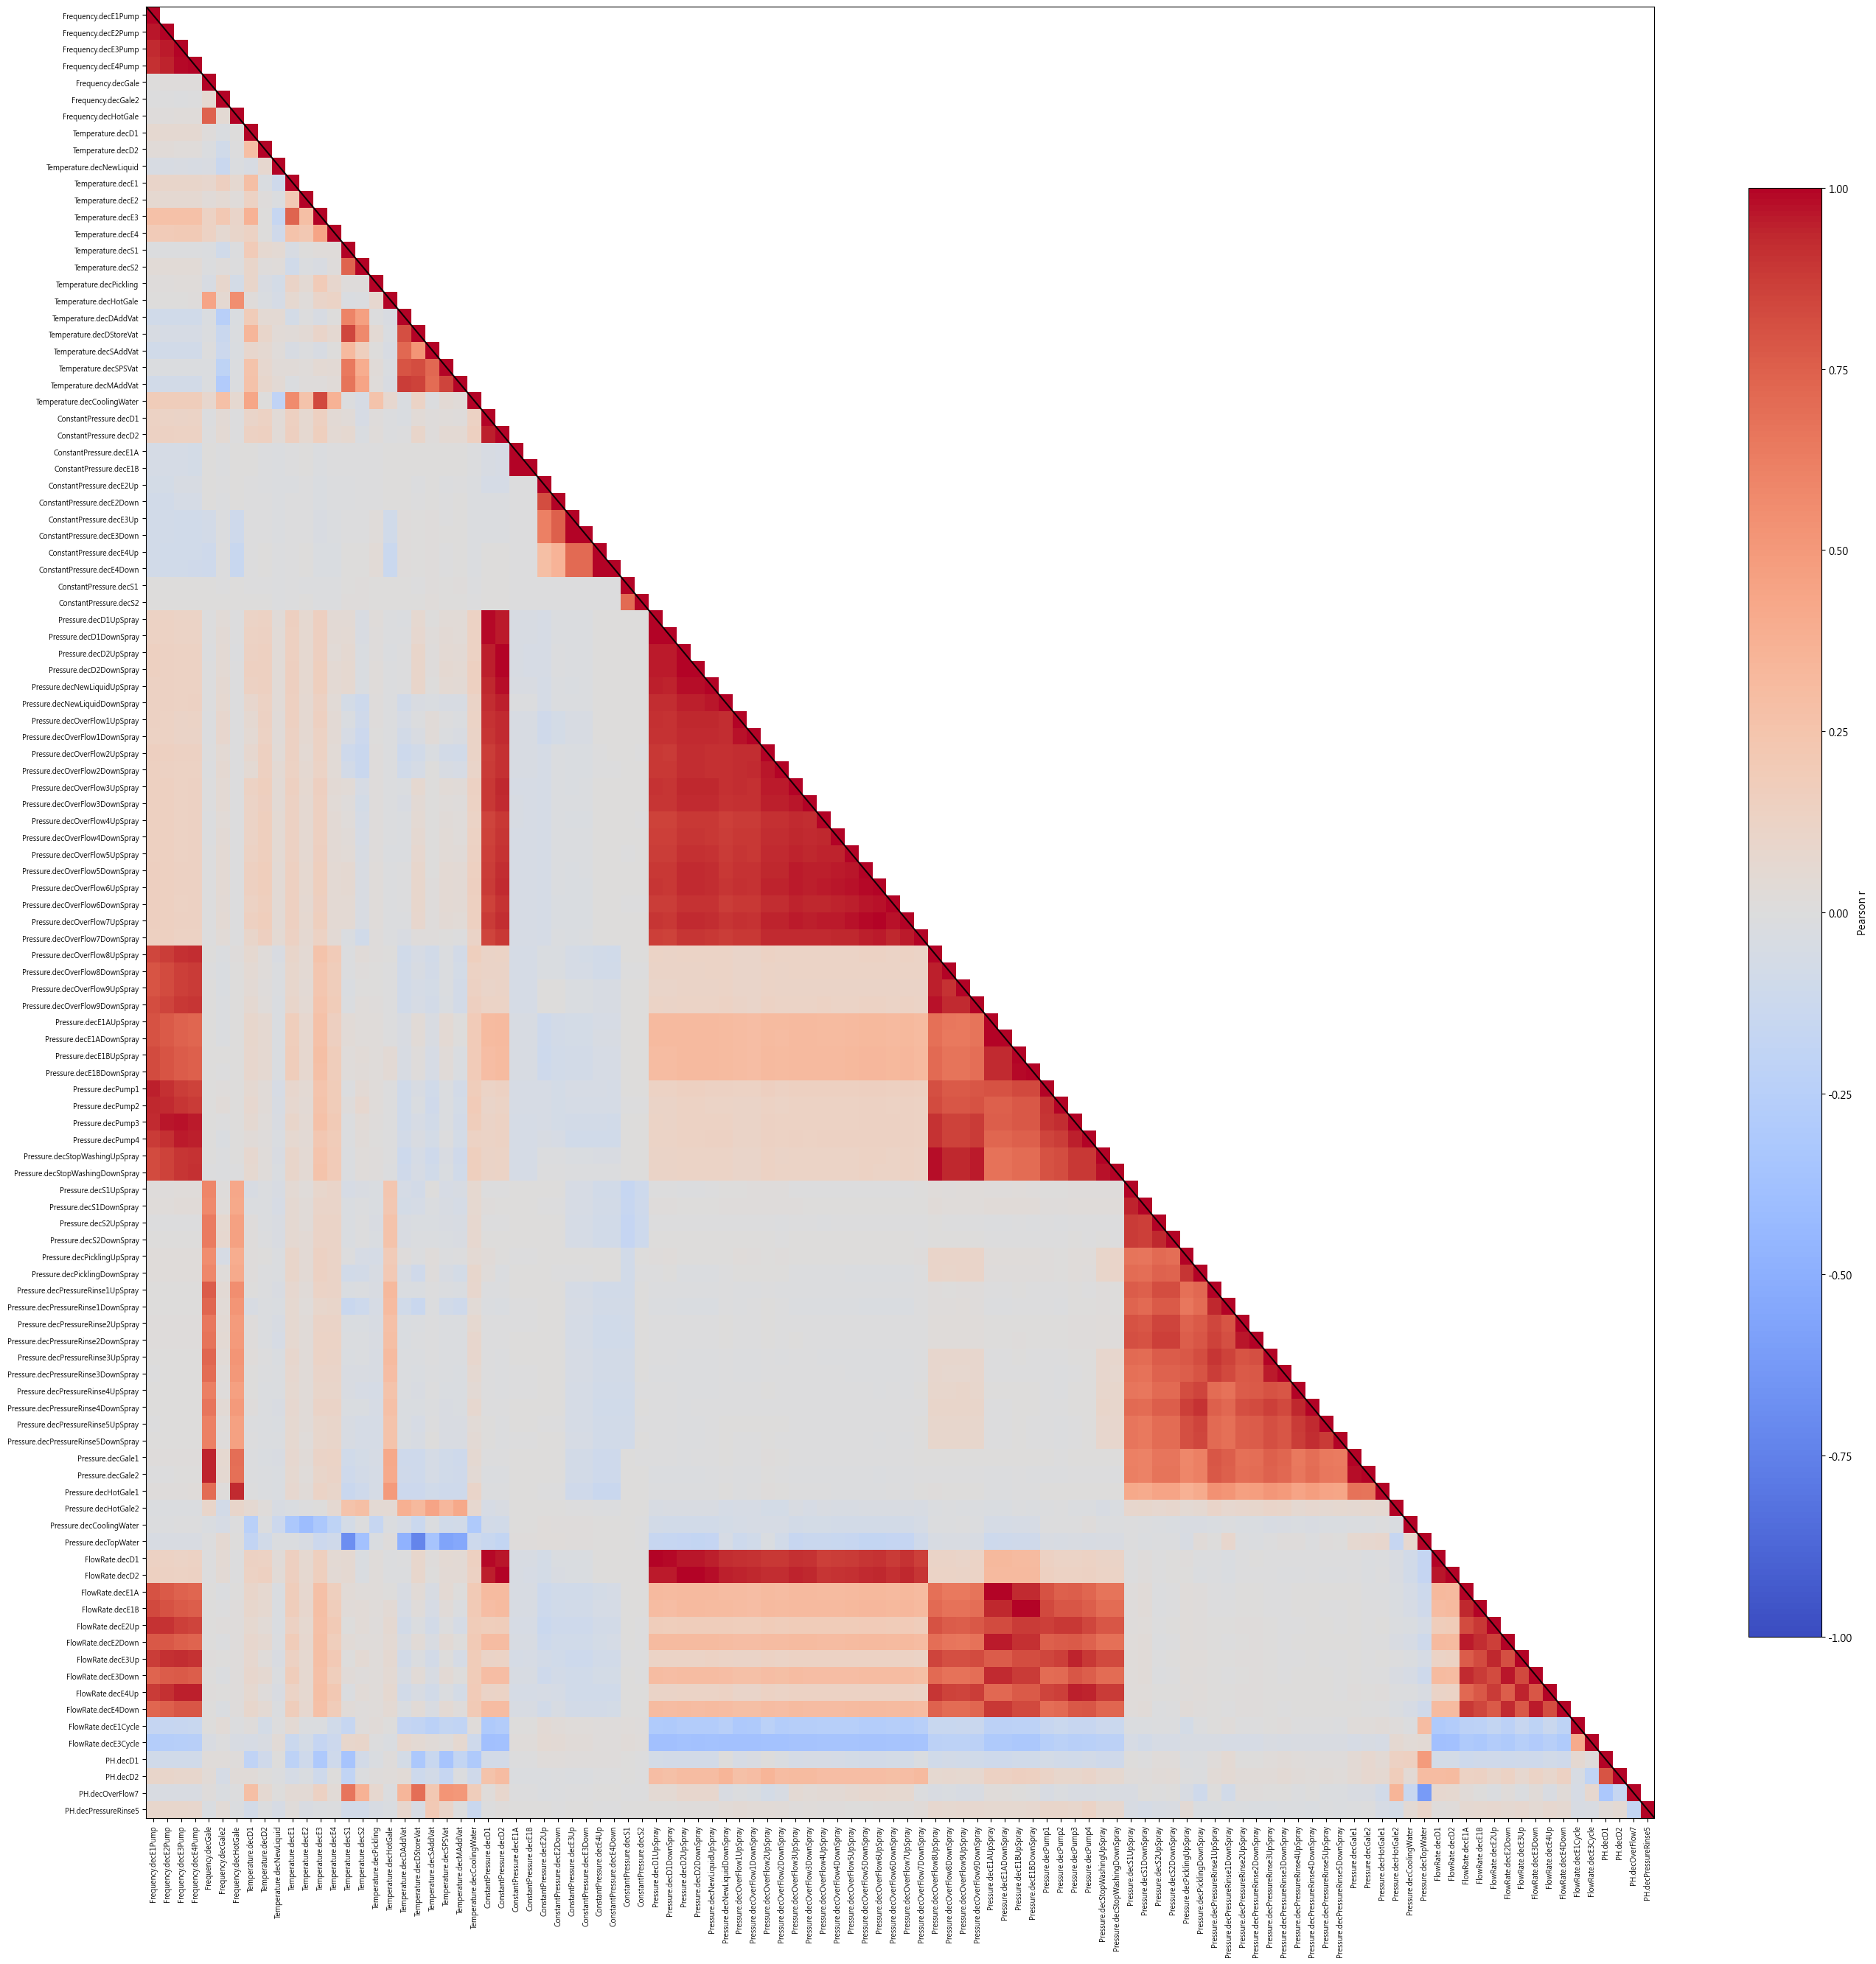

In [32]:
# corr 是你算好的相關矩陣(DataFrame)
import numpy as np, matplotlib.pyplot as plt

n=len(corr)
mask=np.triu(np.ones_like(corr,dtype=bool),k=1)   # 遮掉右上角(對角線以上)
cmap=plt.get_cmap("coolwarm").copy();cmap.set_bad("white")  # 被遮住的格子塗白

fig,ax=plt.subplots(figsize=(max(10,0.22*n+4),max(8,0.22*n+3)))
im=ax.imshow(corr.mask(mask),vmin=-1,vmax=1,cmap=cmap,aspect="auto")
ax.set_xticks(np.arange(n));ax.set_yticks(np.arange(n))
ax.set_xticklabels(corr.columns,rotation=90,fontsize=7)
ax.set_yticklabels(corr.index,fontsize=7)
plt.colorbar(im,ax=ax,shrink=0.8,label="Pearson r")
ax.plot([-0.5,n-0.5],[-0.5,n-0.5],color="k",lw=1.5,alpha=0.9)  # 對角線
plt.tight_layout();plt.show()
